In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from scipy.misc import imsave, imshow
import pyopencl as cl

In [2]:
# load example image
img = ndimage.imread('./shibascarf.jpg')
height, width, channels = img.shape
print 'h', height, 'w', width, 'c', channels

h 270 w 340 c 3


In [3]:
def show(img):
    plt.axis("off")
    plt.imshow(img, interpolation='none', vmin = 0, vmax = 255)

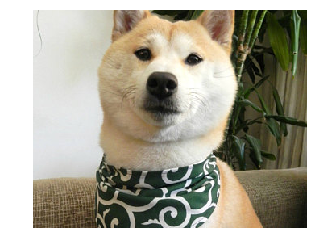

In [4]:
show(img)

In [5]:
# Precompute gaussian derivative kernel for convolution on GPU  
def gaussian_derivative(scale=1):
    #calculate sample points
    K = np.ceil(np.float32(3*scale))
    x = np.arange(-K, K+1) # -K, -K+1, ..., 0, ..., K-1, K
    
    #sample gaussian and normalize (zero-order 1D kernel)
    Gs = np.exp( -x**2 / (2*scale**2) )
    Gs = Gs / np.sum(Gs)
    
    gaussian_kernel = Gs
    #gaussian first derivative kernel
    gaussian_derivative_kernel = -x/(scale**2) * Gs
    
    return gaussian_kernel, gaussian_derivative_kernel

In [46]:
%%timeit
# OpenCL stuff starts here
platforms = cl.get_platforms()
ctx = cl.Context(
        dev_type=cl.device_type.GPU,
        properties=[(cl.context_properties.PLATFORM, platforms[0])])
print ctx
queue = cl.CommandQueue(ctx)

mf = cl.mem_flags

# Precompute gaussian kernel and gaussian derivative kernel.
# We need to do this before defining the GPU program kernel
# because filter size must be known at compile time.
print "Computing Gaussian filter kernels..."
sigma = 4
gaussian_kernel, gaussian_derivative_kernel = gaussian_derivative(sigma)

# Some constants used later
VERTICAL = 0
HORIZONTAL = 1
HALF_MASK_SIZE = int(np.floor(len(gaussian_kernel)/2))

# Two implementations of 1-D convolution, one naive and one with memory-access optimizations via local buffers
print "Compiling GPU program..."
prg = cl.Program(ctx, """
#define BLOCK_SIZE 16
#define HALF_MASK_SIZE """+str(HALF_MASK_SIZE)+"""
#define VERTICAL """+str(VERTICAL)+"""
#define HORIZONTAL """+str(HORIZONTAL)+"""

inline int2 reflect(int2 i, const int h, const int w) {
  // todo: ask raph if there's a way to speed this up with bit-twiddling instead of branches
  // maybe the compiler is smart enough?
  int2 ret = i;
  if (i.x < 0) {
    ret.x = abs(i.x);
  }
  if (i.x > w - 1) {
    ret.x = w - 1 - (i.x - (w - 1));
  }
  if (i.y < 0) {
    ret.y = abs(i.y);
  }
  if (i.y > h - 1) {
    ret.y = h - 1 - (i.y - (h - 1));
  }
  return ret;
}

// Use plain old integer coords | Don't do anything fancy for out of bounds access | Don't do interpolation
const sampler_t sampler = CLK_NORMALIZED_COORDS_FALSE | CLK_ADDRESS_NONE | CLK_FILTER_NEAREST;

__kernel void convolve_1d_naive(__read_only image2d_t img,
                                __constant float * mask_g,
                                const int halfMaskSize,
                                const int axis,
                                __write_only image2d_t out)
{
    const int2 pos = {get_global_id(0), get_global_id(1)};
    const int width = get_global_size(0);
    const int height = get_global_size(1);

    float4 sum = (float4)(0,0,0,0);

    for (int a = -halfMaskSize; a < halfMaskSize+1; a++) {
        int2 shifted_pos;
        // TODO: pos + (0, a)
        if (axis == 0) {
            shifted_pos = (int2)(pos.x  , pos.y+a);
        } else {
            shifted_pos = (int2)(pos.x+a, pos.y  );
        }
        const int2 rpos = reflect(shifted_pos, height, width);
        sum += mask_g[a+halfMaskSize] * read_imagef(img, sampler, rpos);
    }

    write_imagef(out, pos, sum);
}


__kernel void convolve_1d_horizontal_local(__read_only image2d_t img,
                                           __constant float * mask,
                                           const int halfMaskSize,
                                           __write_only image2d_t out)
{
    const int2 pos = {get_global_id(0), get_global_id(1)};
    const int width = get_global_size(0);
    const int height = get_global_size(1);
    
    // Need a region surrounding each block for out-of-workgroup loads
    // TODO: make this a 1d array and use x+y*width for index
    __local float4 cache[BLOCK_SIZE+HALF_MASK_SIZE*2][BLOCK_SIZE];

    // Local id of work-item can be thought of as "local coords within block"
    const int localX = get_local_id(0);
    const int localY = get_local_id(1);
    
    // We're doing vertical 1D convolution, so cacheX == localX,
    // but cacheY needs to be offset by HALF_MASK_SIZE to account for the
    // extra pixels that are outside the workgroup
    const int cacheX = localX+HALF_MASK_SIZE;
    const int cacheY = localY;
    
    // Each work-item reads its corresponding pixel into the cache
    cache[cacheX][cacheY] = read_imagef(img, sampler, pos);
    
    // Now we load some extra pixels around the boundary of the workgroup into the cache.
    // If a work-item is within HALF_MASK_SIZE of an edge, it needs to load a pixel from beyond that edge.
    // We are doing 1-D convolution, so for each work-item, we need to load at most 1 other pixel.
    // It could be the case that our image is smaller than our gaussian filter, but we're just going to ignore
    // that case for now.
    
    // TODO: only need to reflect when get_local_id == 0 and get_local_id == width
    
    // pixel too close to left edge of workgroup
    int2 rpos;
    if (localX < HALF_MASK_SIZE) {
        cache[cacheX-HALF_MASK_SIZE][cacheY] = read_imagef(img, sampler, 
                                                           reflect(pos-(int2)(HALF_MASK_SIZE, 0), height, width));
    }
    // pixel too close to right edge of workgroup
    else if (localX > BLOCK_SIZE - HALF_MASK_SIZE) {
        cache[cacheX+HALF_MASK_SIZE][cacheY] = read_imagef(img, sampler,
                                                           reflect(pos+(int2)(HALF_MASK_SIZE, 0), height, width));
    }
    
    // Sync all work-items in this workgroup
    barrier(CLK_LOCAL_MEM_FENCE);

    // Do the convolution
    float4 sum = (float4)(0,0,0,0);

    for (int a = -halfMaskSize; a < halfMaskSize+1; a++) {
        const int2 rpos = reflect(pos + (int2)(a, 0), height, width);
        sum += mask[a+halfMaskSize] * read_imagef(img, sampler, rpos);
    }

    write_imagef(out, pos, sum);
}
""").build()

# Copy data from host to device
print "Uploading input image..."
in_g = cl.image_from_array(ctx, img.astype(np.float32), 3)
print "Uploaded image from host"

print "Uploading gaussian filters..."
gaussian_kernel_g = cl.Buffer(ctx, mf.READ_ONLY  | mf.COPY_HOST_PTR, hostbuf=gaussian_kernel.astype(np.float32))
gaussian_derivative_kernel_g = cl.Buffer(ctx, mf.READ_ONLY  | mf.COPY_HOST_PTR, hostbuf=gaussian_derivative_kernel.astype(np.float32))
print "Uploaded gaussian filters"

# Create an image2d output buffer
print "Creating output buffer"
fmt = cl.ImageFormat(cl.channel_order.RGBA, cl.channel_type.FLOAT)
out_g = cl.Image(ctx, mf.READ_WRITE, fmt, shape=(width, height))
print "Created output buffer"

# Grab references to the kernels. When we do attribute access on prg, it creates an instance of each kernel.
# Because of this, we need to do `foo = prg.foo; foo.bar` and not just `prg.foo.bar`.
convolve_1d_naive = prg.convolve_1d_naive
convolve_1d_naive.set_scalar_arg_dtypes( [None, None, np.int32, np.int32, None] )
convolve_1d_horizontal_local = prg.convolve_1d_horizontal_local
convolve_1d_horizontal_local.set_scalar_arg_dtypes( [None, None, np.int32, None] )

for _ in xrange(100):
    #convolve_1d_naive(queue, (width, height), None, in_g, gaussian_kernel_g, HALF_MASK_SIZE, HORIZONTAL, out_g)
    convolve_1d_horizontal_local(queue, (width, height), None, in_g, gaussian_kernel_g, HALF_MASK_SIZE, out_g)
    cl.enqueue_copy(queue, in_g, out_g, src_origin=(0, 0), dest_origin=(0, 0), region=(width, height))

result_np = np.empty((height, width, 4), np.float32)
cl.enqueue_copy(queue, result_np, out_g, origin=(0, 0), region=(width, height))

# Show results. We need to slice away the alpha channel and convert back to bytes.
#show(result_np[:,:,:3].astype(np.uint8))
#imsave('/tmp/images/blurry_shibe_naive.png', result_np[:,:,:3].astype(np.uint8))

<pyopencl.Context at 0x7fdcd9d3f230 on <pyopencl.Device 'Intel(R) Iris(TM) Graphics 6100' on 'Apple' at 0x1024500>>
Computing Gaussian filter kernels...
Compiling GPU program...
Uploading input image...
Uploaded image from host
Uploading gaussian filters...
Uploaded gaussian filters
Creating output buffer
Created output buffer
<pyopencl.Context at 0x7fdcd9d3f230 on <pyopencl.Device 'Intel(R) Iris(TM) Graphics 6100' on 'Apple' at 0x1024500>>
Computing Gaussian filter kernels...
Compiling GPU program...
Uploading input image...
Uploaded image from host
Uploading gaussian filters...
Uploaded gaussian filters
Creating output buffer
Created output buffer
<pyopencl.Context at 0x7fdcd9cbde70 on <pyopencl.Device 'Intel(R) Iris(TM) Graphics 6100' on 'Apple' at 0x1024500>>
Computing Gaussian filter kernels...
Compiling GPU program...
Uploading input image...
Uploaded image from host
Uploading gaussian filters...
Uploaded gaussian filters
Creating output buffer
Created output buffer
<pyopencl.Con

<pyopencl.Context at 0x7fdcd9d804b0 on <pyopencl.Device 'Intel(R) Iris(TM) Graphics 6100' on 'Apple' at 0x1024500>>
Computing Gaussian filter kernels...
Compiling GPU program...
Uploading input image...
Uploaded image from host
Uploading gaussian filters...
Uploaded gaussian filters
Creating output buffer
Created output buffer
<pyopencl.Context at 0x7fdcd89a67c0 on <pyopencl.Device 'Intel(R) Iris(TM) Graphics 6100' on 'Apple' at 0x1024500>>
Computing Gaussian filter kernels...
Compiling GPU program...
Uploading input image...
Uploaded image from host
Uploading gaussian filters...
Uploaded gaussian filters
Creating output buffer
Created output buffer
<pyopencl.Context at 0x7fdcd981f1d0 on <pyopencl.Device 'Intel(R) Iris(TM) Graphics 6100' on 'Apple' at 0x1024500>>
Computing Gaussian filter kernels...
Compiling GPU program...
Uploading input image...
Uploaded image from host
Uploading gaussian filters...
Uploaded gaussian filters
Creating output buffer
Created output buffer
<pyopencl.Con

In [40]:
%%timeit
for _ in xrange(100):
    convolve_1d_naive(queue, (width, height), None, in_g, gaussian_kernel_g, HALF_MASK_SIZE, HORIZONTAL, out_g)
    cl.enqueue_copy(queue, in_g, out_g, src_origin=(0, 0), dest_origin=(0, 0), region=(width, height))

result_np = np.empty((height, width, 4), np.float32)
cl.enqueue_copy(queue, result_np, out_g, origin=(0, 0), region=(width, height))



10 loops, best of 3: 102 ms per loop


In [42]:
%%timeit
for _ in xrange(100):
    convolve_1d_horizontal_local(queue, (width, height), None, in_g, gaussian_kernel_g, HALF_MASK_SIZE, out_g)
    cl.enqueue_copy(queue, in_g, out_g, src_origin=(0, 0), dest_origin=(0, 0), region=(width, height))

result_np = np.empty((height, width, 4), np.float32)
cl.enqueue_copy(queue, result_np, out_g, origin=(0, 0), region=(width, height))


10 loops, best of 3: 63.5 ms per loop
